# Hotel Project #

Consists of:
- main.py
- random_allocation_strategy.py
- price_allocation_strategy.py
- preference_allocation_strategy.py
- availability_allocation_strategy.py
- data_visualization.py
- utils.py

The purpose of this program is to analyze and visualize different methods of hotel room allocation based on customer preferences, random allocation, price, and room availability. 
For each of the allocations, the generated data is displayed in three plots as follows:

In [26]:
import pandas as pd
import openpyxl
hotels=pd.read_excel(r"/Users/tesi/Downloads/hotels/hotels.xlsx")
hotels

,Unnamed: 0,hotel,rooms,price
0,0,hotel_1,13,273
1,1,hotel_2,18,92
2,2,hotel_3,12,141
3,3,hotel_4,18,157
4,4,hotel_5,7,298
...,...,...,...,...
395,395,hotel_396,5,212
396,396,hotel_397,12,68
397,397,hotel_398,14,102
398,398,hotel_399,16,284


In [27]:
guests=pd.read_excel(r"/Users/tesi/Downloads/hotels/guests.xlsx")
guests

,Unnamed: 0,guest,discount
0,0,guest_1,0.09
1,1,guest_2,0.00
2,2,guest_3,0.07
3,3,guest_4,0.00
4,4,guest_5,0.10
...,...,...,...
3995,3995,guest_3996,0.00
3996,3996,guest_3997,0.15
3997,3997,guest_3998,0.07
3998,3998,guest_3999,0.08


In [28]:
preferences=pd.read_excel(r"/Users/tesi/Downloads/hotels/preferences.xlsx")
preferences

,Unnamed: 0,guest,hotel,priority
0,0,guest_1,hotel_168,1
1,1,guest_1,hotel_207,2
2,2,guest_1,hotel_222,3
3,3,guest_1,hotel_124,4
4,4,guest_1,hotel_223,5
...,...,...,...,...
99528,99528,guest_4000,hotel_123,28
99529,99529,guest_4000,hotel_396,29
99530,99530,guest_4000,hotel_161,30
99531,99531,guest_4000,hotel_330,31


In [29]:
import pandas as pd
from utils import calc_degree_satisfaction
import random

class RandomAllocator:
    def __init__(self, hotels, guests, preferences):
        self.hotels = hotels
        self.guests = guests
        self.preferences = preferences
        self.allocation = pd.DataFrame(columns=['guest_no', 'hotel_no', 'satisfaction_percentage', 'price_to_pay'])

    def random_hotel(self, guest_no, guest_row):
        # Filters the hotels that have more than 0 remaining available rooms
        remaining_hotels = self.hotels[self.hotels['rooms'] > 0]

        if remaining_hotels.empty:
            return None
        # Choose a random hotel from the remaining hotels group
        random_remaining_hotel_row = remaining_hotels.sample(n=1, random_state=20).iloc[0]
        # Decrease the number of available rooms, calculate price and % of satisfaction
        remaining_hotels.at[random_remaining_hotel_row.name, 'rooms'] -= 1
        price_to_pay = (1 - guest_row['discount']) * random_remaining_hotel_row['price']
        satisfaction = calc_degree_satisfaction(guest_no, random_remaining_hotel_row.name, self.preferences)

        #  Return a dictionary containing information about the allocated room for the guest
        return {
            'guest_no': guest_no,
            'hotel_no': random_remaining_hotel_row.name,
            'satisfaction_percentage': satisfaction,
            'price_to_pay': price_to_pay
        }

    def allocate_randomly(self):
        # Shuffle the guests
        randomized_guests = self.guests.sample(frac=1, random_state=42)
        # A loop that iterates over the randomized guests and randomly allocates a room to the specified guest
        for guest_no, guest_row in randomized_guests.iterrows():
            allocated_in = self.random_hotel(guest_no, guest_row)
            # If the guest has been accommodated the information about the room is appended
            if allocated_in:
                self.allocation.loc[len(self.allocation)] = allocated_in
        return self.allocation




In [30]:
import pandas as pd
from utils import calc_degree_satisfaction

class PriceAllocator:
    def __init__(self, hotels, guests, preferences):
        self.hotels = hotels
        self.guests = guests
        self.preferences = preferences
        self.allocation = pd.DataFrame(columns=['guest_no', 'hotel_no', 'satisfaction_percentage', 'price_to_pay'])

    def available_rooms(self, empty_rooms, hotel_no, hotel_row):
        # Exclude guests who are accommodated
        not_accommodated_guest = self.guests[~self.guests.index.isin(self.allocation['guest_no'])]
        available_guests = not_accommodated_guest.head(empty_rooms)

        # Creates a loop that iterates until all guests are accommodated
        if not available_guests.empty:
            # Calculate price to be paid
            price_to_pay = hotel_row['price'] * (1 - available_guests['discount'])
            # Create row in dataframe with information about available guests and their allocation
            new_rows = pd.DataFrame({
                'guest_no': available_guests.index,
                'hotel_no': hotel_no,
                'satisfaction_percentage': [0] * len(available_guests),
                'paid_price': price_to_pay.tolist()
            })
            # Add rows to the allocation dataframe for each available guest
            for _, row in new_rows.iterrows():
                self.allocation.loc[len(self.allocation)] = row

    def rooms_priority(self, hotel_no, hotel_row):
        # Filters only the guests who have specified a hotel as preference
        prioritized_hotel_guest = self.preferences[self.preferences['hotel'].eq(hotel_no)]['guest']
        # Exclude those who are accommodated
        not_accommodated_guest = prioritized_hotel_guest[~prioritized_hotel_guest.isin(self.allocation['guest_no'])]
        #  Gives the number of empty rooms
        empty_rooms = hotel_row['rooms']

        # Loop that iterates over the guests numbers until there are no more empty rooms
        for guest_no in not_accommodated_guest[:empty_rooms]:
            empty_rooms -= 1

            guest_row = self.guests.loc[guest_no]
            # Calculate price to pay and satisfaction
            price_to_pay = hotel_row['price'] * (1 - guest_row['discount'])
            satisfaction = calc_degree_satisfaction(guest_no, hotel_no, self.preferences)
            # Adds a new row to the dataframe with the information about the allocated room for the guest
            self.allocation.loc[len(self.allocation)] = [guest_no, hotel_no, satisfaction, price_to_pay]

        return empty_rooms

    def allocate_by_price(self):
        # Sort the hotels so that the ones with more available rooms come first
        sorted_hotels = self.hotels.sort_values(by='price')
        # A loop that iterates over the sorted hotels
        # Allocates rooms to guests based on priority for the current hotel
        for hotel_no, hotel_row in sorted_hotels.iterrows():
            hotel_available_rooms = self.rooms_priority(hotel_no, hotel_row)
            # If there are available rooms it passes the information below
            self.available_rooms(hotel_available_rooms, hotel_no, hotel_row) if hotel_available_rooms > 0 else None
        return self.allocation




In [31]:
import pandas as pd
from utils import calc_degree_satisfaction

class PreferenceAllocator:
    def __init__(self, hotels, guests, preferences):
        self.hotels = hotels
        self.guests = guests
        self.preferences = preferences
        self.allocation = pd.DataFrame(columns=['guest_no', 'hotel_no', 'satisfaction_percentage', 'price_to_pay'])

    def hotel_preference(self, guest_no, guest_row):
        # Filters the hotels that are prioritized by the guests
        prioritized_hotels = self.preferences[self.preferences['guest'] == guest_no]['hotel']

        # Loop that iterates through the prioritized hotels for specified guest
        for _, prioritized_hotel_id in prioritized_hotels.items():
            prioritized_hotel_row = self.hotels.loc[prioritized_hotel_id]
            # While there are available rooms in prioritized hotel
            # Calculate price and % of satisfaction
            for _ in range(prioritized_hotel_row['rooms']):
                price_to_pay = (1 - guest_row['discount']) * prioritized_hotel_row['price']
                satisfaction = calc_degree_satisfaction(guest_no, prioritized_hotel_id, self.preferences)
                # Result contains information about the allocated room for the current guest
                result = [guest_no, prioritized_hotel_id, satisfaction, price_to_pay]
                return result
        return None

    def allocate_by_priority(self):
        # A loop that iterates over the guests and allocates a room to the specified guest according to preference
        for guest_no, guest_row in self.guests.iterrows():
            allocated_in = self.hotel_preference(guest_no, guest_row)
            # If the guest has been accommodated the information about the room is appended
            if allocated_in:
                self.allocation.loc[len(self.allocation)] = allocated_in
        return self.allocation



In [32]:
import pandas as pd
from utils import calc_degree_satisfaction
import numpy as np

class AvailableRoomAllocator:
    def __init__(self, hotels, guests, preferences):
        self.hotels = hotels
        self.guests = guests
        self.preferences = preferences
        self.allocation = pd.DataFrame(columns=['guest_no', 'hotel_no', 'satisfaction_percentage', 'price_to_pay'])

    def allocate_available_rooms(self, empty_rooms, hotel_no, hotel_row):
        # Exclude guests who are accommodated
        not_accommodated_guests = self.guests[~self.guests.index.isin(self.allocation['guest_no'])]
        available_guests = not_accommodated_guests.head(empty_rooms)

        # Creates a loop that iterates until all guests are accommodated
        if not available_guests.empty:
            # Calculate price to be paid
            price_to_pay = hotel_row['price'] * (1 - available_guests['discount'])
            # Create row in dataframe with information about available guests and their allocation
            new_rows = pd.DataFrame({
                'guest_no': available_guests.index,
                'hotel_no': hotel_no,
                'satisfaction_percentage': np.zeros(len(available_guests)),
                'paid_price': price_to_pay.tolist()
            })

            # Add rows to the allocation dataframe for each available guest
            for _, row in new_rows.iterrows():
                self.allocation.loc[len(self.allocation)] = row

    def allocate_rooms_priority(self, hotel_no, hotel_row):
        # Filters only the guests who have specified a hotel as preference
        prioritized_hotel_guest = self.preferences[self.preferences['hotel'].eq(hotel_no)]['guest']
        # Exclude those who are accommodated
        not_accommodated_guest = prioritized_hotel_guest[~prioritized_hotel_guest.isin(self.allocation['guest_no'])]
        #  Gives the number of empty rooms
        empty_rooms = hotel_row['rooms']

        # Loop that iterates over the guests numbers until there are no more empty rooms
        for guest_no in not_accommodated_guest[:empty_rooms]:
            empty_rooms -= 1

            guest_row = self.guests.loc[guest_no] # Retrieve row that corresponds to guest number
            # Calculate price to pay and satisfaction
            price_to_pay = hotel_row['price'] * (1 - guest_row['discount'])
            satisfaction = calc_degree_satisfaction(guest_no, hotel_no, self.preferences)
            # Adds a new row to the dataframe with the information about the allocated room for the guest
            self.allocation.loc[len(self.allocation)] = [guest_no, hotel_no, satisfaction, price_to_pay]

        return empty_rooms

    def allocate_by_availability(self):
        # Sort the hotels so that the ones with more available rooms come first
        sorted_hotels = self.hotels.sort_values(by='rooms', ascending=False)
        # A loop that iterates over the sorted hotels
        # Allocates rooms to guests based on priority for the current hotel
        for hotel_no, hotel_row in sorted_hotels.iterrows():
            hotel_available_rooms = self.allocate_rooms_priority(hotel_no, hotel_row)
            # If there are available rooms it passes the information below
            self.allocate_available_rooms(hotel_available_rooms, hotel_no, hotel_row) if hotel_available_rooms > 0 else None
        return self.allocation


In [33]:
import matplotlib.pyplot as plt
import numpy as np

# Function to create plots and visualize the data
def visualize_allocation(allocation):
    figure, (p1, p2, p3) = plt.subplots(1, 3, figsize=(20, 8))

    # Plot 1: Total earnings for each hotel
    tot_earnings = allocation.groupby('hotel_no')['price_to_pay'].sum()
    tot_earnings.plot(kind='bar', ax=p1, color='#B98FE5')
    p1.set_title(r'Total Earnings of Hotel', fontweight='bold')
    p1.set_xlabel(r'Hotel No.', fontweight='bold')
    p1.set_ylabel(r'Total Earnings', fontweight='bold')

    # Plot 2: Degree of satisfaction for each customer
    deg_satisfaction = allocation.groupby('guest_no')['satisfaction_percentage'].mean()
    deg_satisfaction.plot(kind='bar', ax=p2, color='#97BF98')
    p2.set_title(r'Degree of Customer Satisfaction', fontweight='bold')
    p2.set_xlabel('Guest No.', fontweight='bold')
    p2.set_ylabel('Degree of Satisfaction', fontweight='bold')

    # Plot 3: Create data for the bar plot
    categories = ['No. of Guests Allocated', 'No. of Rooms Occupied', 'No. of Hotels Occupied']
    values = np.array([len(allocation), len(allocation), allocation['hotel_no'].nunique()])

    # Create a bar plot
    p3.bar(categories, values, color=['#ACD3D4', '#EEDBA7', '#EEA7D3'])
    p3.set_title(r'Allocation Statistics', fontweight='bold')
    p3.set_ylabel('Count')

    # Display the counts on top of the bars
    for i, v in enumerate(values):
        p3.text(i, v + 0.1, str(v), ha='center', va='bottom', fontweight='bold')

    plt.tight_layout(
                     pad=1.08,
                     h_pad=None,
                     w_pad=None,
                     rect=None)
    plt.show()


In [34]:
def print_allocation_data(allocation):

    # Prints the data from the allocation DataFrame.
    print("\nAllocation Data:")
    print(allocation)

    # Prints out total earnings of the hotel by performing the sum and grouping by the number of hotel and the price
    total_earnings = allocation.groupby('hotel_no')['price_to_pay'].sum()
    print("\nTotal Earnings for Each Hotel:")
    print(total_earnings)

    # Prints out degree of satisfaction by performing the mean and grouping by the number of the guest and the satisfaction %
    deg_satisfaction = allocation.groupby('guest_no')['satisfaction_percentage'].mean()
    print("\nDegree of Satisfaction for Each Customer:")
    print(deg_satisfaction)

    # Performs the actions to get these data and then print it out using dictionaries
    allocation_statistics = {
        'No. of Guests Allocated': len(allocation),
        'No. of Rooms Occupied': len(allocation),
        'No. of Hotels Occupied': allocation['hotel_no'].nunique()
    }

    print("\nAllocation Statistics:")
    for category, value in allocation_statistics.items():
        print(f"{category}: {value}")

    print()

def calc_degree_satisfaction(guest_no, hotel_no, preferences):

    # Creates a dataframe that contains the preferences of the specified guest
    pref_of_guest = preferences[preferences['guest'] == guest_no].reset_index()
    # It then checks if the guest has no recorded preference and if they do not it returns 100% satisfaction
    if pref_of_guest.empty:
        return 100

    # then calculates the satisfaction percentage according to the guest's preferences
    # these actions are performed in order to get the index where the guest's preference matches the specified hotel,
    # then divided to get the position of the guests rank of priorities then turned into % of satisfaction

    return round((1 - pref_of_guest['hotel'].eq(hotel_no).idxmax() / len(pref_of_guest)) * 100) \
        if hotel_no in pref_of_guest['hotel'].values \
        else 0
    # If it does not satisfy the preference it returns 0




    This program visualizes the data generated from the different methods of allocation.
    For each of the allocations, the generated data is displayed in three plots as follows:
    
Random Allocation


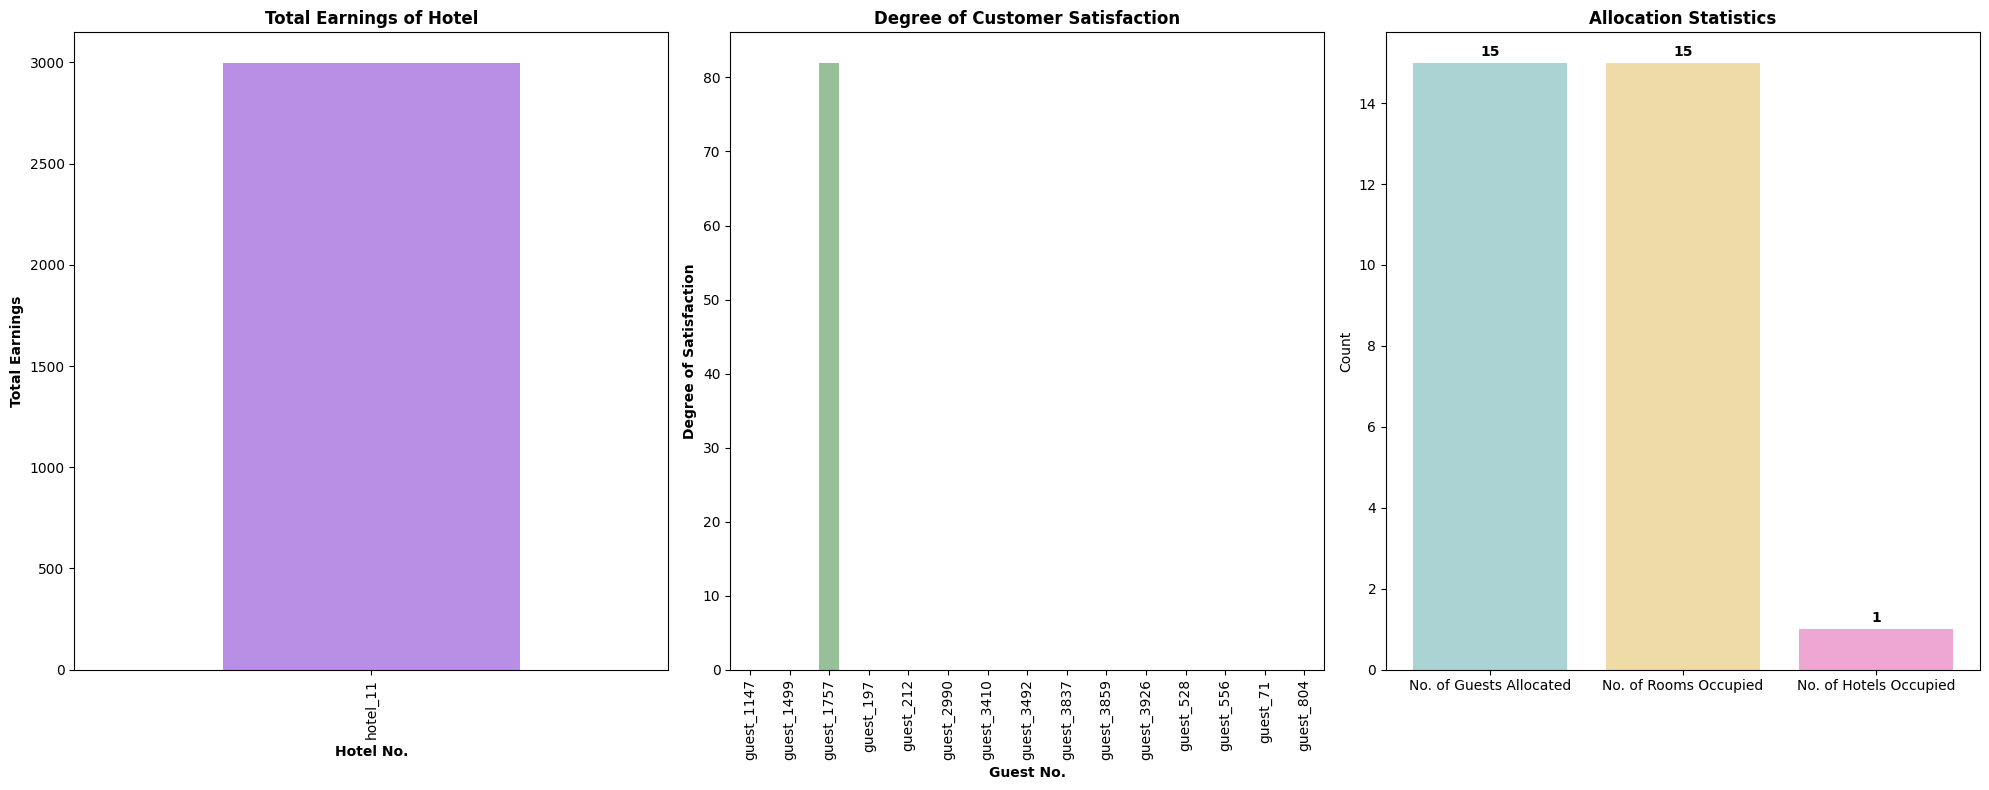


Allocation Data:
        guest_no  hotel_no  satisfaction_percentage  price_to_pay
0      guest_556  hotel_11                        0        189.84
1     guest_3492  hotel_11                        0        194.36
2      guest_528  hotel_11                        0        187.58
3     guest_3926  hotel_11                        0        216.96
4     guest_2990  hotel_11                        0        198.88
...          ...       ...                      ...           ...
3995  guest_1131  hotel_11                        0        223.74
3996  guest_1295  hotel_11                        0        203.40
3997   guest_861  hotel_11                        0        210.18
3998  guest_3508  hotel_11                        0        226.00
3999  guest_3175  hotel_11                        0        201.14

[4000 rows x 4 columns]

Total Earnings for Each Hotel:
hotel_no
hotel_11    819071.46
Name: price_to_pay, dtype: float64

Degree of Satisfaction for Each Customer:
guest_no
guest_1       0

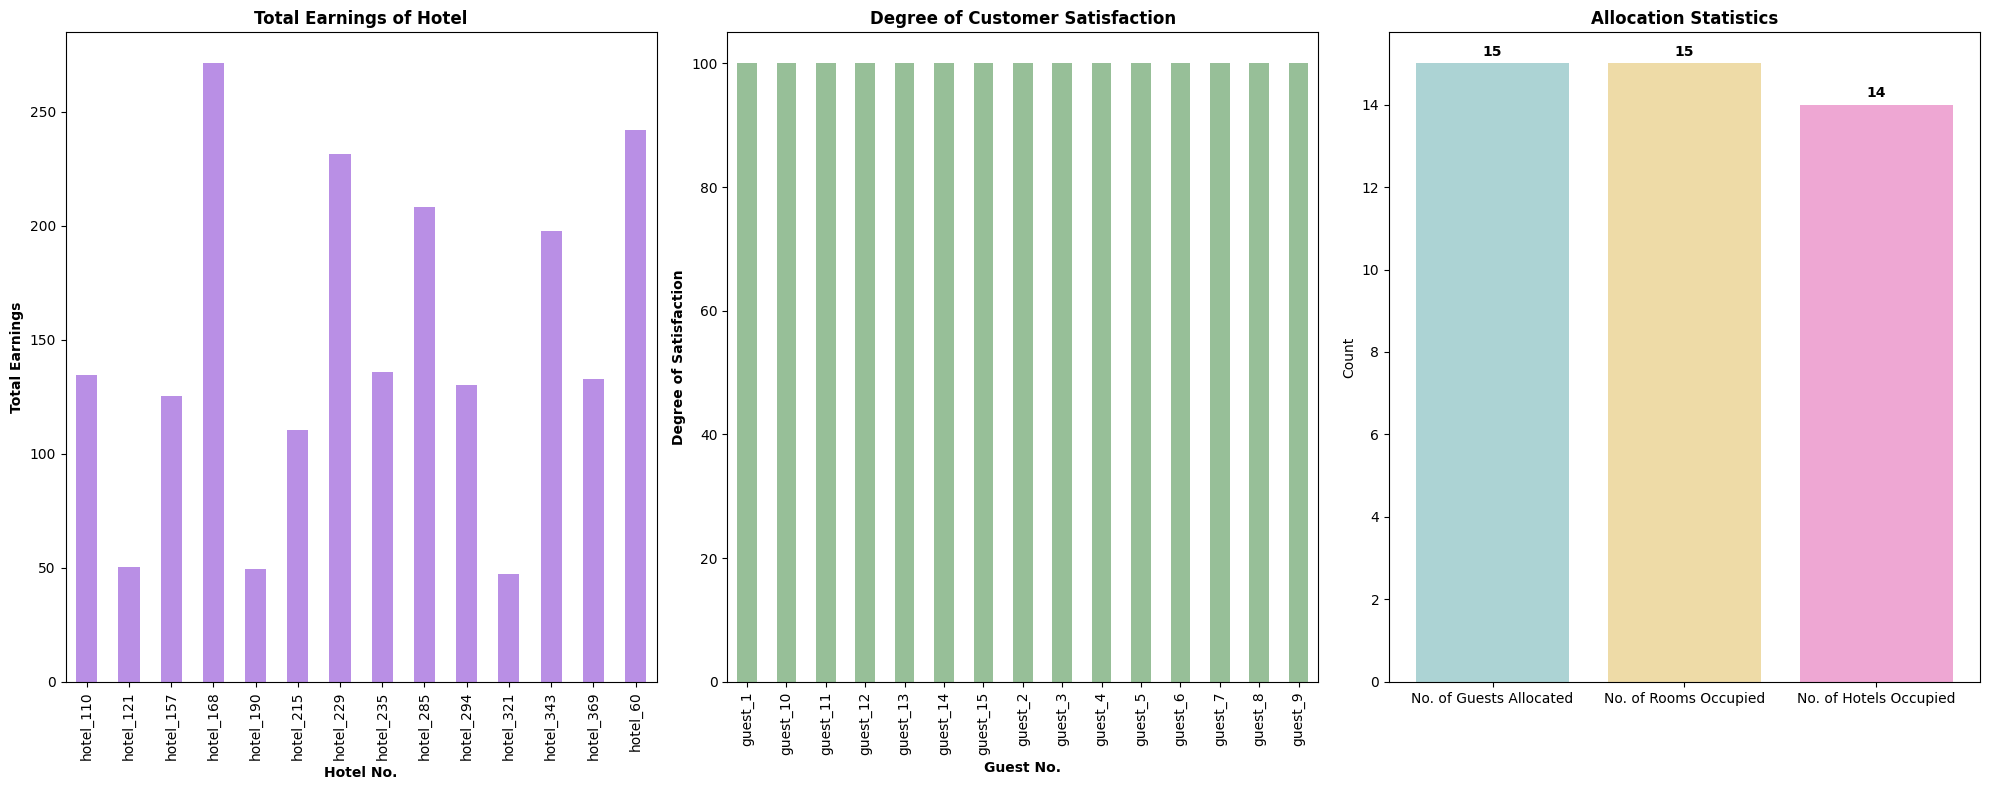


Allocation Data:
        guest_no   hotel_no  satisfaction_percentage  price_to_pay
0        guest_1  hotel_168                      100        271.18
1        guest_2  hotel_369                      100        133.00
2        guest_3  hotel_157                      100         60.45
3        guest_4  hotel_235                      100        136.00
4        guest_5  hotel_121                      100         50.40
...          ...        ...                      ...           ...
3995  guest_3996  hotel_350                      100         56.00
3996  guest_3997   hotel_19                      100         96.05
3997  guest_3998  hotel_160                      100         63.24
3998  guest_3999  hotel_277                      100        258.52
3999  guest_4000  hotel_275                      100        147.87

[4000 rows x 4 columns]

Total Earnings for Each Hotel:
hotel_no
hotel_1      2451.54
hotel_10     2690.64
hotel_100     840.00
hotel_101    2297.32
hotel_102    1015.43
       

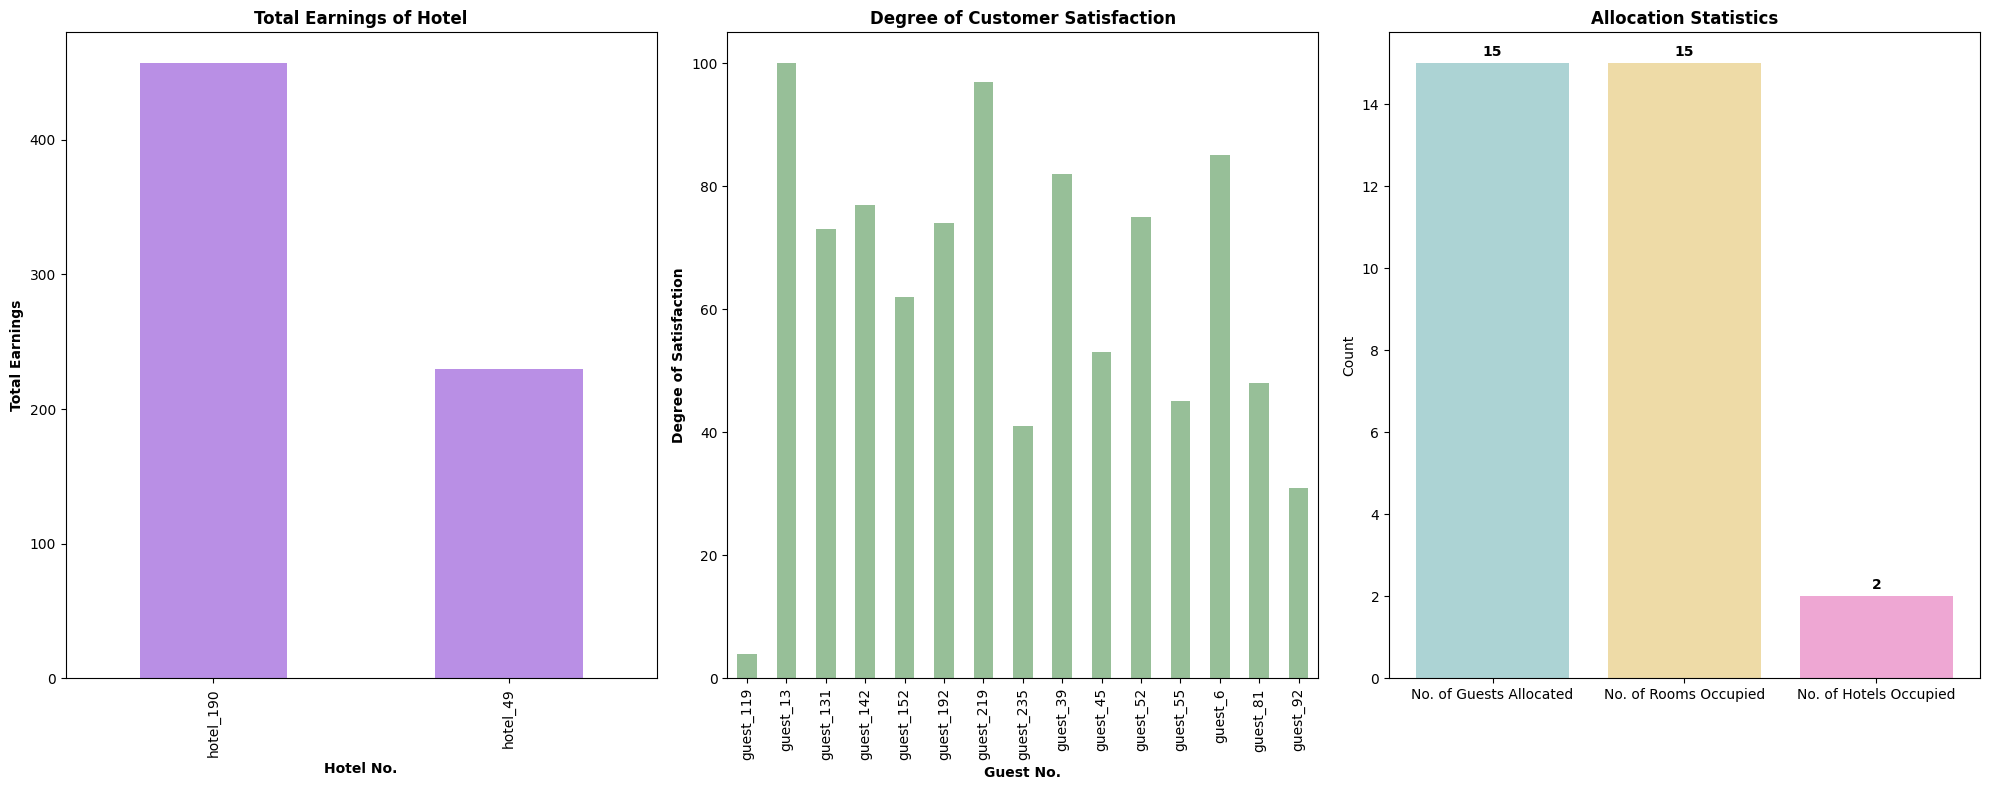


Allocation Data:
        guest_no   hotel_no  satisfaction_percentage  price_to_pay
0       guest_13  hotel_190                      100          49.5
1       guest_39  hotel_190                       82          44.0
2       guest_81  hotel_190                       48          50.0
3      guest_119  hotel_190                        4          45.0
4      guest_131  hotel_190                       73          42.0
...          ...        ...                      ...           ...
3995  guest_3970  hotel_270                        0           NaN
3996  guest_3975  hotel_270                        0           NaN
3997  guest_3979  hotel_270                        0           NaN
3998  guest_3982  hotel_270                        0           NaN
3999  guest_3993  hotel_270                        0           NaN

[4000 rows x 4 columns]

Total Earnings for Each Hotel:
hotel_no
hotel_10     2084.58
hotel_100    2718.40
hotel_101    2137.74
hotel_102     971.63
hotel_103    1747.25
       

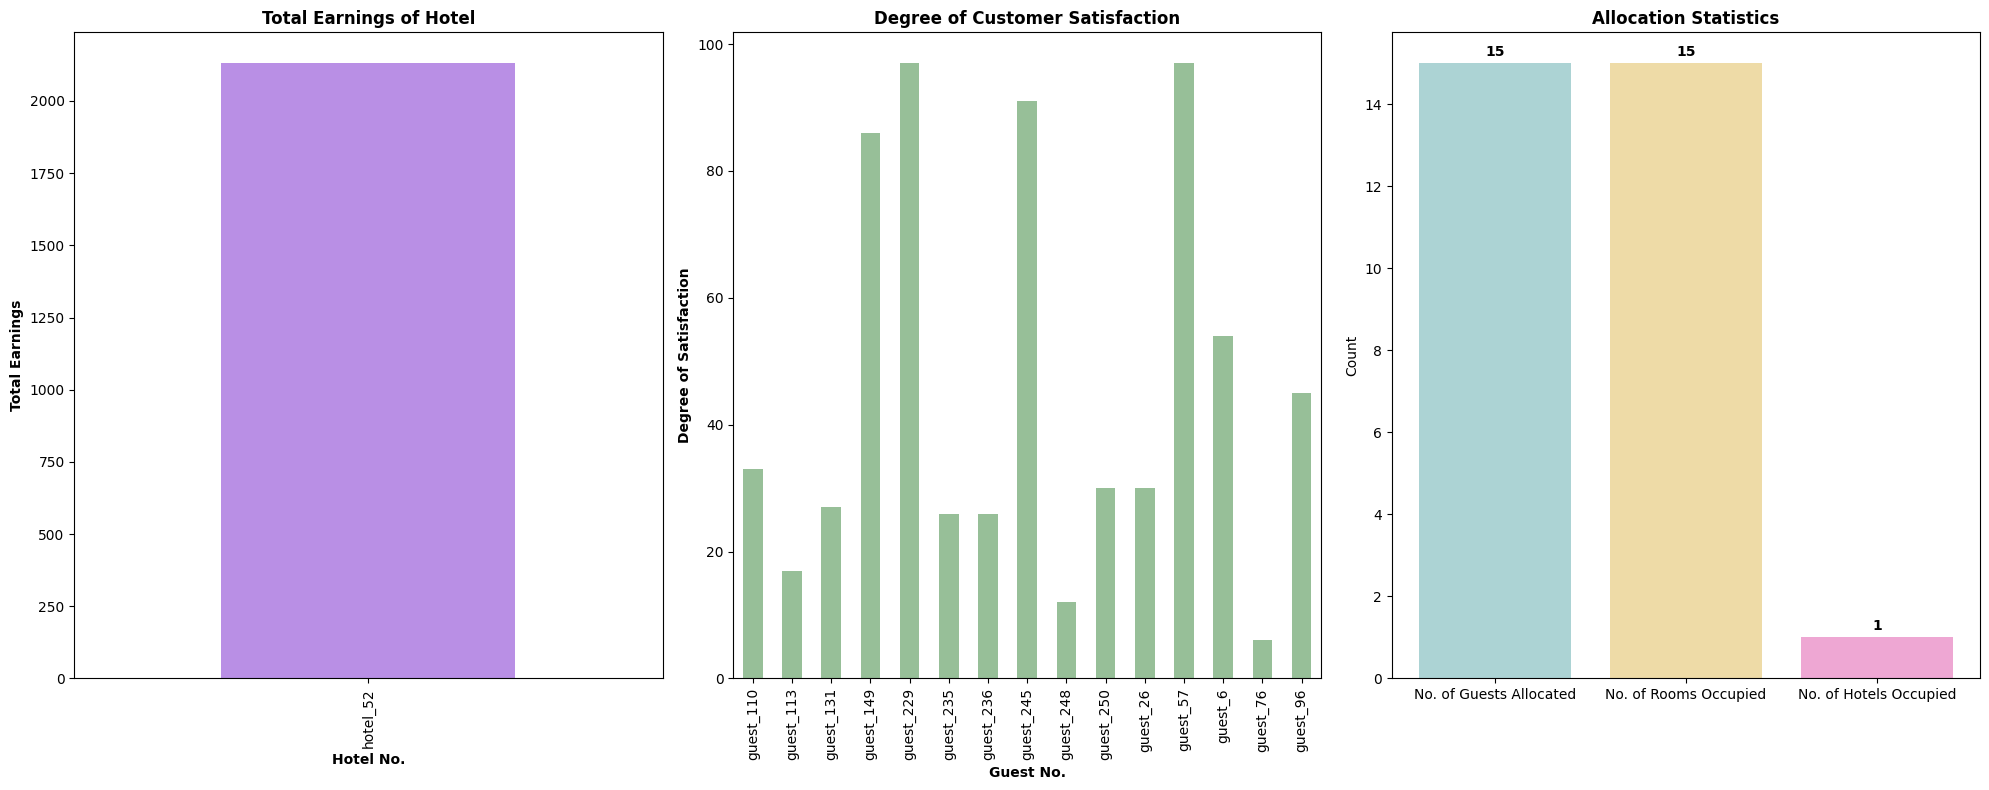


Allocation Data:
        guest_no   hotel_no  satisfaction_percentage  price_to_pay
0        guest_6   hotel_52                     54.0        141.96
1       guest_26   hotel_52                     30.0        154.44
2       guest_57   hotel_52                     97.0        151.32
3       guest_76   hotel_52                      6.0        146.64
4       guest_96   hotel_52                     45.0        138.84
...          ...        ...                      ...           ...
3995  guest_3952  hotel_347                      0.0           NaN
3996  guest_3958  hotel_347                      0.0           NaN
3997  guest_3970  hotel_347                      0.0           NaN
3998  guest_3975  hotel_347                      0.0           NaN
3999  guest_3999  hotel_347                      0.0           NaN

[4000 rows x 4 columns]

Total Earnings for Each Hotel:
hotel_no
hotel_1      3177.72
hotel_10     1966.92
hotel_100    2748.80
hotel_101    2087.18
hotel_102    1017.62
       

In [41]:
import pandas as pd
from random_allocation_strategy import RandomAllocator
from preference_allocation_strategy import PreferenceAllocator
from price_allocation_strategy import PriceAllocator
from availability_allocation_strategy import AvailableRoomAllocator
from data_visualization import visualize_allocation
from utils import print_allocation_data
def main():
    # Read the data from the excel sheets
    hotels = pd.read_excel(r"/Users/tesi/Downloads/hotels/hotels.xlsx").set_index('hotel')
    guests = pd.read_excel(r"/Users/tesi/Downloads/hotels/guests.xlsx").set_index('guest')
    preferences = pd.read_excel(r"/Users/tesi/Downloads/hotels/preferences.xlsx").drop_duplicates(subset=['guest', 'hotel'])

    comment = """
    This program visualizes the data generated from the different methods of allocation.
    For each of the allocations, the generated data is displayed in three plots as follows:
    """

    print(comment)

    # For each allocation, we call the function that does the allocation in terms of preference,
    # price, availability and randomly
    # call the visualize_allocation function to create 3 graphs for each allocation
    # call the print_allocation_data to make a summary of the data that is in the graphs

    random_allocator = RandomAllocator(hotels.copy(), guests, preferences)
    print('Random Allocation')
    allocation_randomly = random_allocator.allocate_randomly()
    visualize_allocation(allocation_randomly.head(15))
    print_allocation_data(allocation_randomly)

    preference_allocator = PreferenceAllocator(hotels.copy(), guests, preferences)
    print('Customer Preference Allocation')
    allocation_by_customer_preference = preference_allocator.allocate_by_priority()
    visualize_allocation(allocation_by_customer_preference.head(15))
    print_allocation_data(allocation_by_customer_preference)

    price_allocator = PriceAllocator(hotels, guests, preferences)
    print('Price Allocation')
    allocation_by_price = price_allocator.allocate_by_price()
    visualize_allocation(allocation_by_price.head(15))
    print_allocation_data(allocation_by_price)

    availability_allocator = AvailableRoomAllocator(hotels, guests, preferences)
    print('Availability Allocation')
    allocation_by_availability = availability_allocator.allocate_by_availability()
    visualize_allocation(allocation_by_availability.head(15))
    print_allocation_data(allocation_by_availability)

if __name__ == "__main__":
    main()